In [1]:
%%capture

!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import fasttext
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.cluster.util import cosine_distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection, svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [3]:
df_raw = pd.read_csv('data/raw/Big_AHR.csv')

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18172 entries, 0 to 18171
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   18172 non-null  int64 
 1   title        18172 non-null  object
 2   rating       18172 non-null  int64 
 3   review_text  18172 non-null  object
 4   location     16356 non-null  object
 5   hotel        16356 non-null  object
 6   label        18172 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 993.9+ KB


In [6]:
df_raw.describe()

,Unnamed: 0,rating,label
count,18172.000000,18172.000000,18172.000000
mean,9085.500000,3.984151,1.103291
std,5245.948881,1.292239,0.798061
min,0.000000,1.000000,0.000000
25%,4542.750000,3.000000,1.000000
50%,9085.500000,4.000000,1.000000
75%,13628.250000,5.000000,1.000000
max,18171.000000,5.000000,3.000000


In [7]:
df_raw.sample(5)

,Unnamed: 0,title,rating,review_text,location,hotel,label
6211,6211,"Si quieren un pésimo WIFI, este es el lugar",3,"El hotel está bien ubicado, muy cerca de la pl...",Malaga_Costa_del_Sol_Province_of_Malaga_Andalucia,Hotel_Soho_Boutique_Los_Naranjos,3
12089,12089,Muy Sorprendidos! Excelente!,4,La verdad quedamos muy sorprendidos de la limp...,Cordoba_Province_of_Cordoba_Andalucia,Albergue_Juvenil_de_Cordoba,1
1028,1028,Nuevo concepto TABLAFINA NH Plaza de Armas,5,"Visitar Sevilla siempre es una maravilla, y su...",Seville_Province_of_Seville_Andalucia,NH_Sevilla_Plaza_de_Armas,1
8538,8538,Atardecer en el mirador,4,Recomendable tomarse un café en el cafetería d...,Granada_Province_of_Granada_Andalucia,Alhambra_Palace_Hotel,1
11159,11159,Extraordinario,5,"Magnifico hotel, muy buena ubicación, cerca de...",Cordoba_Province_of_Cordoba_Andalucia,Hotel_Selu,1


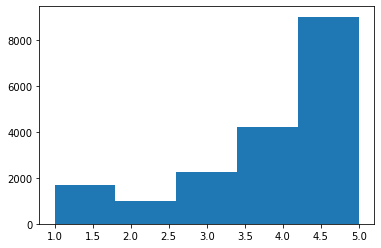

In [9]:
plt.hist(df_raw['rating'], bins=5)
plt.show()

In [12]:
df_raw['hotel'].value_counts()

Carmen_de_Ramilla                                    120
Apartamentos_Mauror                                  100
Hotel_Ho_Ciudad_de_Jaen                               80
Hotel_Xauen                                           80
La_Almunia_del_Valle                                  80
                                                    ... 
Nixar                                                  4
Apartamentos_Turisticos_Vista_Alhambra                 4
La_Esperanza_Granada                                   3
Finca_El_Juncal                                        3
Radisson_Collection_Hotel_Magdalena_Plaza_Sevilla      3
Name: hotel, Length: 715, dtype: int64

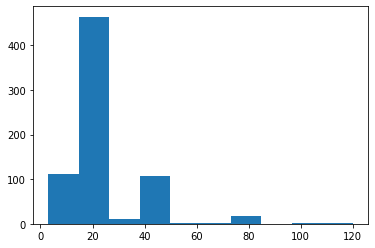

In [14]:
plt.hist(df_raw['hotel'].value_counts())
plt.show()

#### Reseñas neutras (3 estrellas)

In [4]:
df_3_stars = df_raw[df_raw['rating']==3]

In [11]:
for text in df_3_stars['review_text'].sample(5).tolist():
    print(text)
    print()

Es un sitio cómodo en cuanto a su localización. Limpio. Sólo hay una ducha para todos, por lo que hay que correr para pillar sitio. Es una pensión sin más. Lo necesario para cuando pasas todo el día de turismo. Le falta televisión en las habitaciones.

Hotel donde tu te registras. Tu te abres. Tu si quieres te preparas. En pleno centro de Almeria. Cama muy confortable. Baño pequeño. Poco calor de hotel...Si mucha privacidad. Un nuevo concepto hotel.

De entrada, apenas señalado, si no es por la dirección ni lo encontramos, solo un pequeño cartelito en el portal.  Cuando entras, es practicamente una casa particular.  La mujer que lo lleva es muy maja, pero algo despistada.  La habitación no tenía cortinas, solo un toldo para el sol de la mañana, que no era suficiente.  La habitación en estas fechas fría, a pesar de tener radiador, estaban apagados, aunque la mujer indicó que nos iba a dejar un calefactor para no pasar frío, al final no fué así y las dos noches las pasamos regular.  Otra

En esta muestra de reseñas neutras se ve que los comentarios destacan tanto aspectos positivos como negativos. 
A continuación se intenta separar cada comentario en oraciones, para su clasificación en positivas y negativas.

In [12]:
# Eliminar columnas que no corresponden a texto de la reseña
def delete_columns(df):
    df = df.drop(['label', 'hotel', 'location', 'rating', 'Unnamed: 0'], axis=1)
    return df

In [14]:
df_3_stars = delete_columns(df_3_stars)

In [15]:
# Crear una columna que combine title y review
def combine_texts(df):
    df['text'] = df['title'].astype(str)+'. '+df['review_text'].astype(str)
    return df

In [16]:
df_3_stars = combine_texts(df_3_stars)

In [18]:
# Crear lista con cada oración (separada por .) por separado
lista_text = df_3_stars['text'].tolist()

sentences = []

for line in lista_text:
    line = line.rstrip()
    oraciones = line.split('.')
    for oracion in oraciones:
        oracion = oracion.lstrip(' ')
        sentences.append(oracion)
sentences = list(filter(None, sentences))

In [19]:
# Convertir la lista anterior a dataframe
df_sentences_3_stars = pd.DataFrame (sentences, columns = ['text'])

In [20]:
# Limpieza del texto
def preprocess_column(df):
    df['text_processed'] = df['text'].str.strip().str.lower()
    caracteres = ['!', ',', '&', ':', ';', '(', ')', '.', '?', '"']
    for car in caracteres:
        df['text_processed'] = df['text_processed'].str.replace(car,'', regex=False)
    df['text_processed'] = df['text_processed'].str.normalize('NFKC')
    df['text_processed'] = df['text_processed'].str.replace(r'([a-zA-Z])\1{2,}', r'\1', regex=True) 
    return df

In [21]:
df_sentences_3_stars = preprocess_column(df_sentences_3_stars)

In [22]:
# Normalizar el texto (eliminar tildes, diéresis, etc)
def normalize_str(text_string):
    if text_string is not None:
        result = unicodedata.normalize('NFD', text_string).encode('ascii', 'ignore').decode()
    else:
        result = None
    return result

In [23]:
df_sentences_3_stars['text_processed'] = df_sentences_3_stars['text_processed'].apply(normalize_str)

In [24]:
# Sustituye caracteres no alfanuméricos
def non_alphanumeric(texto):
    return re.sub("(\\W)+"," ", texto)

In [25]:
df_sentences_3_stars['text_processed'] = df_sentences_3_stars['text_processed'].apply(non_alphanumeric)

In [26]:
#Sustituye los espacios dobles entre palabras
def multiple_esp(texto):
    return re.sub(' +', ' ',texto)

In [27]:
df_sentences_3_stars['text_processed'] = df_sentences_3_stars['text_processed'].apply(multiple_esp)

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/gitpod/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
stop_words = stopwords.words('spanish')

In [23]:
print(stop_words)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [31]:
# No se quiere remover del texto las palabras que cambian el sentido de la expresión (por ejemplo "no")
for word in ['no', 'sin', 'nada']:
    stop_words.remove(word)

In [32]:
# Remover "hotel", que aparece en la mayoría de las reseñas y no aporta significativamente al análisis
stop_words.append('hotel')

In [33]:
# Normalizar stopwords
for i in range(len(stop_words)):
    stop_words[i] = normalize_str(stop_words[i])

In [34]:
# Función para eliminar las stopwords incluidas en la lista creada
def remove_stopwords(text_string):
    word_tokens = word_tokenize(text_string)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    sentence = ' '.join(str(x) for x in filtered_sentence)
    return sentence

In [35]:
df_sentences_3_stars['text_processed'] = df_sentences_3_stars['text_processed'].apply(remove_stopwords)

In [38]:
df_sentences_3_stars.sample(3)

,text,text_processed
13409,Se escuchaba por todo el patio y en su habitac...,escuchaba patio habitacion no digno quitarse t...
13604,"El hotel es céntrico, que para las visitas a l...",centrico visitas ciudad bien limpio remodelado...
7088,Lo mejor el personal y la ubicación,mejor personal ubicacion


In [39]:
# Guardar el dataframe como csv
df_sentences_3_stars.to_csv('data/interim/sentences_3_stars.csv')

Para realizar una clasificación de cada oración (en positiva y negativa) es necesario hacer el mismo procesamiento con las demás reseñas. 
Este procedimiento está hecho en create_df_sentences.py

Al usar las reseñas positivas y negativas para el entrenamiento se está asumiendo que todas las oraciones de un comentario positivo son positivas (y que todas las oraciones de un comentario negativo son negativas), lo cual no tiene por qué ser cierto, y por lo tanto se introduce cierto error. Para minimizar este error, se utiliza para el entrenamiento solo las reseñas con 1 estrella y 5 estrellas.

In [40]:
df_sentences_1_star = pd.read_csv('data/interim/sentences_1_star.csv')
df_sentences_5_stars = pd.read_csv('data/interim/sentences_5_stars.csv')

In [55]:
df_sentences_1_star.sample(3)

,text,text_processed
5763,"La habitación es minúscula, el somier de la ca...",habitacion minuscula somier cama pico facil cl...
3584,Decepcionada,decepcionada
3939,Lo peor en hoteles que he visto nunca,peor hoteles visto nunca


In [54]:
df_sentences_5_stars.sample(3)

,text,text_processed
50768,Un paraíso,paraiso
30280,Además disponen de una terraza con piscina par...,ademas disponen terraza piscina poder mitigar ...
18218,"gracias Diego,gracias Juan y gracias Mujer peg...",gracias diegogracias juan gracias mujer pegada...


In [56]:
# Agregar columna para indicar sentimiento
df_sentences_1_star['label'] = 0
df_sentences_5_stars['label'] = 1

In [57]:
# Combinar en un solo df las oraciones positivas y negativas
df_sentences_labeled = pd.concat([df_sentences_1_star, df_sentences_5_stars])

##### Construcción del modelo para clasificar oraciones

In [58]:
X = df_sentences_labeled['text_processed']
y = df_sentences_labeled['label']

In [59]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=12)

In [60]:
vec = CountVectorizer()

X_train = vec.fit_transform(X_train.values.astype('U')).toarray()
X_val = vec.transform(X_val.values.astype('U')).toarray()

In [61]:
classifier = svm.SVC(C=1.0, kernel='linear', gamma='auto')

In [62]:
classifier.fit(X_train, y_train)

In [ ]:
predictions_train = classifier.predict(X_train)

print('Train:')
print(classification_report(y_train, predictions_train))

In [ ]:
predictions_val = classifier.predict(X_val)

print('Val:')
print(classification_report(y_val, predictions_val))

In [53]:
# Búsqueda de hiperparámetros
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1 , 0.01], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(random_state=1234), param_grid, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
